# Segmentez des clients d'un site e-commerce - *Notebook simulation*

In [2]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn

from sklearn.impute import KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_blobs

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.manifold import TSNE

from sklearn.utils import resample

from yellowbrick.cluster import KElbowVisualizer

from scipy.cluster.hierarchy import dendrogram, linkage

import timeit
import warnings

from datetime import datetime, timedelta

# pour cartographie
import folium
import cartopy.crs as ccrs
import geopandas as gpd
import contextily as ctx

import sqlite3

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

print("folium version", folium.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
folium version 0.19.2


## 1 - Démarche

J'utiliserais les mêmes features que celles utilisées dans le 2ème essai; c'est à dire :
- récence
- fréquence
- montant
- score_moyen

Voici les étapes :
- **T0 :** entraînement initial du modèle M0 sur le dataset X_0, créé à partir de toutes les commandes passées jusqu’à T0.
    - L'entraînement de ce modème génére la liste des clusters C0=M0.fit_predict(X_0).
- **T1 :**  entrainement du nouveau modème M1 sur le dataset X_1, créé à partir de toutes les commandes passées jusqu’à T1.
    - L'entraînement de ce modème génére la liste des clusters C1_new=M1.fit_predict(X_1).
    - On fait ensuite une nouvelle prédiction avec M0 sur M1 ==> C1_init = M0.predict(X_1).
    - On calcule l'ARI entre C1 et C1_init avec adjusted_rand_score avec sklearn.
- **T2 :**  entrainement du nouveau modème M2 sur le dataset X_2, créé à partir de toutes les commandes passées jusqu’à T2.
    - L'entraînement de ce modème génére la liste des clusters C2_new=M2.fit_predict(X_2).
    - On fait ensuite une nouvelle prédiction avec M0 sur M2 ==> C2_init = M0.predict(X_2).
    - On calcule l'ARI entre C2_new et C2_init avec adjusted_rand_score avec sklearn.         

## 2 - Création d'une fonction d'extraction du jeu de données par date Ti

J'utilise un accès direct à la base de données olist.db.

La fonction créée pour extraire les données de la base prends le paramètre date_select (T0, T1, T2,...).

Les données extraites sont chargées dans un dataframe.

In [5]:
def get_olist_data_per_order_purchase_timestamp(maxDate):

    """
    Récupère les données agrégées des commandes à une date spécifiée à partir de la base de données Olist.

    Cette fonction exécute une requête SQL pour calculer les métriques RFM (Récence, Fréquence, Montant) 
    ainsi que le score moyen des avis clients pour chaque client unique, en utilisant une date d'achat 
    maximale comme référence. Elle retourne un DataFrame contenant ces métriques agrégées.

    Args:
        maxDate (str): La date et l'heure maximale pour les commandes à analyser, au format 
                       'YYYY-MM-DD HH:MM:SS'.

    Returns:
        pandas.DataFrame: Un DataFrame avec les colonnes suivantes pour chaque client unique :
            - recence (int): Nombre de jours depuis la dernière commande.
            - frequence (int): Nombre de commandes distinctes passées par le client.
            - montant (float): Montant total dépensé par le client.
            - score_moyen (float): Note moyenne des avis donnés par le client.

    Raises:
        sqlite3.OperationalError: Si une erreur survient lors de l'exécution de la requête SQL.
        sqlite3.ProgrammingError: Si les paramètres de la requête ne correspondent pas au nombre attendu.

    Example:
        >>> df = get_olist_data_per_order_purchase_timestamp("2018-10-17 17:30:18")
        >>> print(df.head())

    Notes:
        - Cette fonction utilise SQLite pour interagir avec la base de données.
        - La connexion à la base de données est fermée après l'exécution.
        - La colonne "customer_unique_id" est exclue du DataFrame retourné.
    """
    
    # Connexion à une base SQLite (ou création si elle n'existe pas)
    conn = sqlite3.connect('C:/Users/admin/Documents/Projets/Projet_5/olist.db')
    
    # Créer un curseur
    cursor = conn.cursor()

    # Requête SQL
    query = """
                WITH orders_filter AS (
                	SELECT * 
                		FROM orders o 
                		WHERE o.order_purchase_timestamp < :maxDate
                ),
                latest_order AS(
                	SELECT max(order_purchase_timestamp) AS max_purchase_date
                FROM orders_filter
                ),
                orders_join_rfm AS(
                	SELECT c.customer_unique_id,
                	       CAST(julianday((SELECT max_purchase_date FROM latest_order)) - julianday(MAX(o.order_purchase_timestamp)) AS INTEGER) AS recence,
                    	   COUNT(DISTINCT o.order_id) AS frequence,
                    	   SUM(oi.price) AS montant
                	    FROM customers c
                	    LEFT JOIN orders_filter o ON c.customer_id = o.customer_id
                	    LEFT JOIN order_items oi ON o.order_id = oi.order_id
                		GROUP BY c.customer_unique_id
                ),
                review_joins AS(
                	SELECT c.customer_unique_id, AVG(or2.review_score) AS score_moyen
                		FROM customers c
                		INNER JOIN orders_filter o ON o.customer_id = c.customer_id
                		INNER JOIN order_reviews or2 ON or2.order_id = o.order_id
                		GROUP BY c.customer_unique_id 
                ),
                aggregation AS(
                	SELECT orfm.customer_unique_id, recence, frequence, montant, score_moyen
                		FROM orders_join_rfm orfm
                		LEFT JOIN review_joins rj ON rj.customer_unique_id = orfm.customer_unique_id
                )
                SELECT * 
                	FROM aggregation
                	WHERE recence IS NOT NULL;
            """         

    # Exécution avec paramètre pour maxDate
    cursor.execute(query, {'maxDate': maxDate})
    rows = cursor.fetchall()

    # Fermer la connexion
    conn.close()
    
    # Obtenir les noms de colonnes
    columns = [description[0] for description in cursor.description]

    # Convertir en DataFrame
    df = pd.DataFrame(rows, columns=["customer_unique_id", "recence", "frequence", "montant", "score_moyen"])
    df.drop('customer_unique_id', axis=1, inplace=True)    
    
    return df

Testons la fonction :

In [7]:
df = get_olist_data_per_order_purchase_timestamp("2018-10-17 17:30:18")

df.head()

,recence,frequence,montant,score_moyen
0,159,1,129.90,5.0
1,162,1,18.90,4.0
2,584,1,69.00,3.0
3,368,1,25.99,4.0
4,336,1,180.00,5.0


In [8]:
df.shape

(96095, 4)

## 3 - Création des fonctions de transformation et d'affichage

### 3.1 - Création d'une fonction de transformation des données

In [10]:
def transform_df(df):

    """
    Transforme les données d'un DataFrame en appliquant des traitements sur certaines colonnes.

    Cette fonction effectue plusieurs étapes de prétraitement des données :
    - Remplace les valeurs manquantes (NaN) dans les colonnes 'score_moyen' et 'montant' par la médiane de chaque colonne.
    - Applique une transformation des colonnes 'montant', 'recence' et 'frequence' en utilisant un `QuantileTransformer` pour normaliser les données.
    - Ajoute les nouvelles colonnes normalisées au DataFrame.
    - Supprime les anciennes colonnes 'montant', 'recence' et 'frequence'.

    Args:
        df (pandas.DataFrame): Le DataFrame contenant les données à transformer. Il doit inclure les colonnes 'score_moyen', 
                               'montant', 'recence', et 'frequence'.

    Returns:
        pandas.DataFrame: Le DataFrame transformé avec les nouvelles colonnes normalisées 'montant_norm', 'recence_norm', 
                          et 'frequence_norm' et sans les anciennes colonnes 'montant', 'recence', 'frequence'.

    Example:
        >>> df = pd.DataFrame({
        >>>     'score_moyen': [4.5, np.nan, 3.0, 5.0],
        >>>     'montant': [200, 300, np.nan, 150],
        >>>     'recence': [10, 20, 30, 40],
        >>>     'frequence': [1, 2, 3, 4]
        >>> })
        >>> transformed_df = transform_df(df)
        >>> print(transformed_df.head())

    Notes:
        - La fonction utilise `QuantileTransformer` avec une distribution normale pour normaliser les colonnes numériques.
        - Les valeurs manquantes dans 'score_moyen' et 'montant' sont remplacées par leur médiane respective.
    """
    
    # Remplacer les NaN de la feature "score_moyen" par la médiane
    df['score_moyen'] = df['score_moyen'].fillna(df['score_moyen'].median())

    # Remplacer les NaN de la feature "montant" par la médiane
    df['montant'] = df['montant'].fillna(df['montant'].median())

    # Application de QuantileTransformer (par défaut, transforme en distribution uniforme)
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
    df_transformed = quantile_transformer.fit_transform(df[['montant', 'recence', 'frequence']])

    # Conversion en DataFrame
    columns_to_transform = ['montant_norm', 'recence_norm', 'frequence_norm']
    df_transformed = pd.DataFrame(df_transformed, columns=columns_to_transform)

    # Ajoutons les nouvelles colonnes
    df_transformed.index = df.index
    df[columns_to_transform] = df_transformed
    
    # Supprimons les anciennes
    df.drop(['montant', 'recence', 'frequence'], axis=1, inplace=True) 

    return df

### 3.2 - Création d'une fonction d'affichage des distributions

In [12]:
def print_features_distribution(df):

    """
    Affiche des histogrammes pour chaque colonne d'un DataFrame.

    Cette fonction génère un graphique avec des histogrammes pour chaque colonne numérique
    d'un DataFrame. Chaque histogramme représente la distribution des valeurs dans une
    colonne donnée. Les histogrammes sont organisés dans une grille de sous-graphes.

    Args:
        df (pandas.DataFrame): Le DataFrame contenant les colonnes pour lesquelles les distributions
                               doivent être affichées. Le DataFrame doit contenir des données numériques.

    Returns:
        None: La fonction génère simplement un graphique et l'affiche à l'écran. Aucun objet n'est retourné.

    Example:
        >>> df = pd.DataFrame({
        >>>     'feature_1': [1, 2, 2, 3, 3, 4, 5],
        >>>     'feature_2': [2, 3, 3, 4, 5, 5, 6]
        >>> })
        >>> print_features_distribution(df)

    Notes:
        - La fonction utilise `matplotlib.pyplot` pour la création des graphiques.
        - Les histogrammes sont affichés sur une grille de 3 lignes et 4 colonnes (maximum 12 graphiques).
    """
    
    # Créer des histogrammes pour chaque colonne
    fig = plt.figure(figsize=(14, 10))
    for feat_idx in range(df.shape[1]):  # Pour chaque colonne
        ax = fig.add_subplot(3, 4, feat_idx + 1)  # Ajouter à la grille
        h = ax.hist(df.iloc[:, feat_idx], bins=50, color="steelblue", edgecolor="none")
        ax.set_title(df.columns[feat_idx], fontsize=14)
    
    plt.tight_layout()
    plt.show()

## 4 - Simulation

### 4.1 - T0 - initialisation

**Préparation du jeu de données**

Sélection des commandes passées jusqu'à T0.

In [14]:
X_0 = get_olist_data_per_order_purchase_timestamp("2017-12-31 23:59:59")
X_0.head()

,recence,frequence,montant,score_moyen
0,296,1,69.00,3.0
1,80,1,25.99,4.0
2,47,1,180.00,5.0
3,301,1,135.00,4.0
4,166,1,13.90,3.0


In [15]:
X_0.shape

(44034, 4)

Distribution avant la transformation :

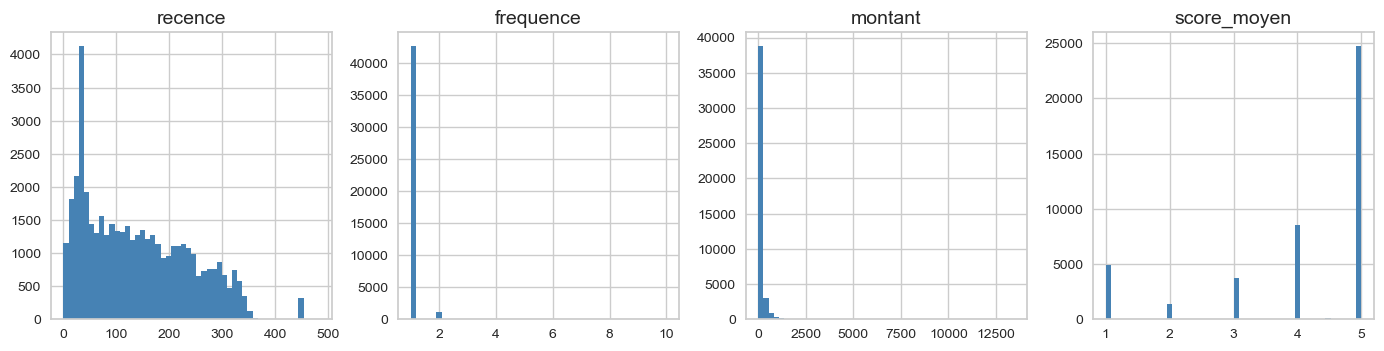

In [17]:
print_features_distribution(X_0)

Transformation des données :

In [19]:
X_0 = transform_df(X_0)
X_0.shape

(44034, 4)

Distribution après la transformation :

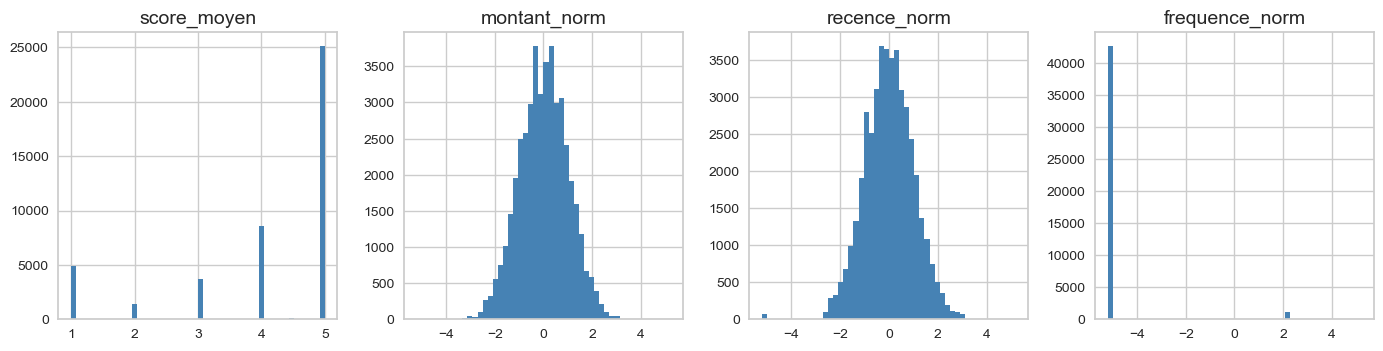

In [21]:
print_features_distribution(X_0)

Centrer et réduire les données :

In [23]:
X_scale_0 = StandardScaler().fit_transform(X_0)
df_0 = pd.DataFrame(X_scale_0, columns=X_0.columns)
df_0.describe()

,score_moyen,montant_norm,recence_norm,frequence_norm
count,4.403400e+04,4.403400e+04,4.403400e+04,4.403400e+04
mean,-3.992103e-16,-1.670100e-17,-2.904521e-18,-3.059429e-16
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-2.316347e+00,-5.233219e+00,-5.206437e+00,-1.717648e-01
25%,-6.674541e-02,-6.882184e-01,-6.619773e-01,-1.717648e-01
50%,6.831219e-01,1.188479e-02,1.016182e-03,-1.717648e-01
75%,6.831219e-01,6.844371e-01,6.655359e-01,-1.717648e-01
max,6.831219e-01,5.199084e+00,5.195919e+00,8.184495e+00


**Entraînement**

Entraînement initial du modèle M0 sur le dataset X_0, créé à partir de toutes les commandes passées jusqu’à T0.

Appliquons le clustering avec k-means et k = 5 :

In [25]:
warnings.filterwarnings("ignore")

In [26]:
M0 = KMeans(n_clusters=5, random_state=42)
C0 = M0.fit_predict(X_scale_0)

Affichons la distribution des clusters :

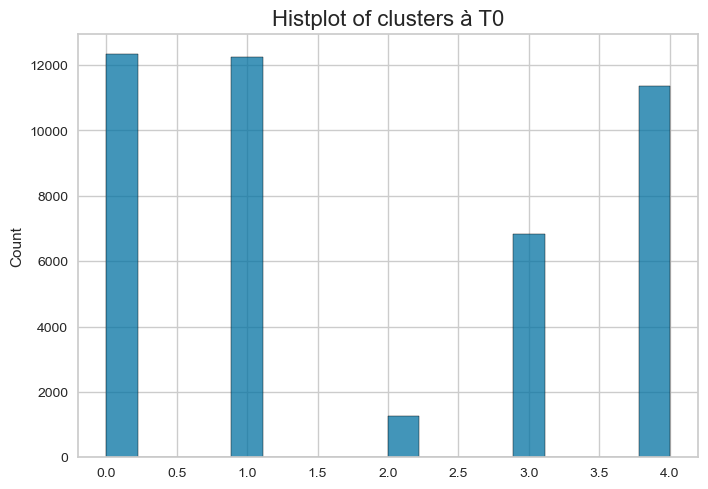

In [28]:
sns.histplot(data=C0)
plt.title('Histplot of clusters à T0', fontsize=16)
plt.show()

### 4.2 - 1ère boucle d'itérations depuis le 31/12/2017

Le principe est d'itérer sur chaque date Ti et de sauvegarder le score ARI de chaque itération pour les afficher sur un graphique après toutes les itérations.

Pour rappel, l'ARI (Adjusted Rand Index) est une mesure statistique utilisée pour évaluer la similarité entre deux regroupements (ou partitions), souvent appliquée pour comparer des résultats de clustering. Il est particulièrement utile pour mesurer la divergence entre des clusters obtenus. Voici comment utiliser l'ARI pour évaluer la divergence des clusters :

L'ARI calcule la proportion d'accords entre deux partitions, en tenant compte du hasard. Sa valeur varie entre :
- -1 (divergence totale),
- 0 (partition aléatoire sans rapport),
- 1 (accord parfait).

Je démarre sur des cylces de 1 semaine depuis le 31/12/2017.

In [30]:
def run_iterations(start_date, num_weeks):

        """
        Run clustering iterations and calculate ARI scores over weekly intervals.

        Parameters:
            start_date (str): The start date in the format 'YYYY-MM-DD HH:MM:SS'.
            num_weeks (int): The number of weekly iterations.
    
        Returns:
            list: A list of tuples containing the week number and the ARI score.
        """
    
    # Initialisation d'une liste pour stocker les résultats ARI
    ari_scores = []
    
    # Convertir la date de départ en datetime
    start_date_obj = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    
    # Boucle sur les cycles de 1 semaine
    for i in range(1, num_weeks + 1):
        # Calculer la nouvelle date de fin pour chaque semaine
        end_date_obj = start_date_obj + timedelta(weeks=i)
        
        # Convertir la date en chaîne de caractères pour la fonction
        end_date_str = end_date_obj.strftime("%Y-%m-%d %H:%M:%S")
        
        # Appeler la fonction avec la date calculée
        X_ = get_olist_data_per_order_purchase_timestamp(end_date_str)
    
        # Nettoyer et transformer les données
        X_ = transform_df(X_)
        
        # Centrer et réduire les données
        X_scale_ = StandardScaler().fit_transform(X_)
    
        # Appliquer le clustering sur le modèle initial
        C_init = M0.predict(X_scale_)
    
        # Appliquer le clustering sur le nouveau modèle
        M_ = KMeans(n_clusters=5, random_state=42)
        C_new = M_.fit_predict(X_scale_)
        
        # Calculer l'ARI entre les clusters prédits par M0 et M_
        ari_score = adjusted_rand_score(C_init, C_new)
    
        # Ajouter le score ARI et le numéro de semaine à la liste
        ari_scores.append((i, ari_score))
    
    # Afficher les résultats ARI avec les numéros de semaine
    print("\nRésultats ARI pour chaque cycle de 1 semaine:")
    for week, score in ari_scores:
        print(f"Semaine {week}: ARI = {score}")

    return ari_scores

In [31]:
def print_ari_scores(ari_scores):

    """
    Plot the evolution of the Adjusted Rand Index (ARI) over weeks.

    Parameters:
        ari_scores (list of tuples): A list of tuples where each tuple contains 
                                     the week number (int) and the ARI score (float).

    Displays:
        A line plot showing the ARI scores over the weeks.
    """
    
    # Récupérer les numéros de semaine et les scores ARI
    semanas = [week for week, _ in ari_scores]
    scores_ari = [score for _, score in ari_scores]
    
    # Créer une figure et un graphique
    plt.figure(figsize=(10, 6))
    
    # Tracer la courbe ARI
    plt.plot(semanas, scores_ari, marker='o', color='steelblue', label='ARI')
    
    # Ajouter des labels et un titre
    plt.title('Evolution de l\'Adjusted Rand Index (ARI) au fil des semaines', fontsize=16)
    plt.xlabel('Nombre de semaines', fontsize=14)
    plt.ylabel('Score ARI', fontsize=14)
    
    # Afficher la grille
    plt.grid(True)
    
    # Ajouter une légende
    plt.legend()
    
    # Afficher la courbe
    plt.show()

In [32]:
ari_scores = run_iterations("2017-12-31 23:59:59", 20)


Résultats ARI pour chaque cycle de 1 semaine:
Semaine 1: ARI = 0.9684721142034466
Semaine 2: ARI = 0.9661847069613647
Semaine 3: ARI = 0.9645975070240643
Semaine 4: ARI = 0.9763027263323492
Semaine 5: ARI = 0.9783241592545162
Semaine 6: ARI = 0.9465278247425132
Semaine 7: ARI = 0.979655941812996
Semaine 8: ARI = 0.9753286963811286
Semaine 9: ARI = 0.9746798138087268
Semaine 10: ARI = 0.7121832106008688
Semaine 11: ARI = 0.9623151182403461
Semaine 12: ARI = 0.907785159587196
Semaine 13: ARI = 0.940363166343988
Semaine 14: ARI = 0.9728856051644108
Semaine 15: ARI = 0.8791745073477235
Semaine 16: ARI = 0.9528734355141344
Semaine 17: ARI = 0.9217723018893474
Semaine 18: ARI = 0.7753360367519466
Semaine 19: ARI = 0.7182005352701714
Semaine 20: ARI = 0.9036033588064855


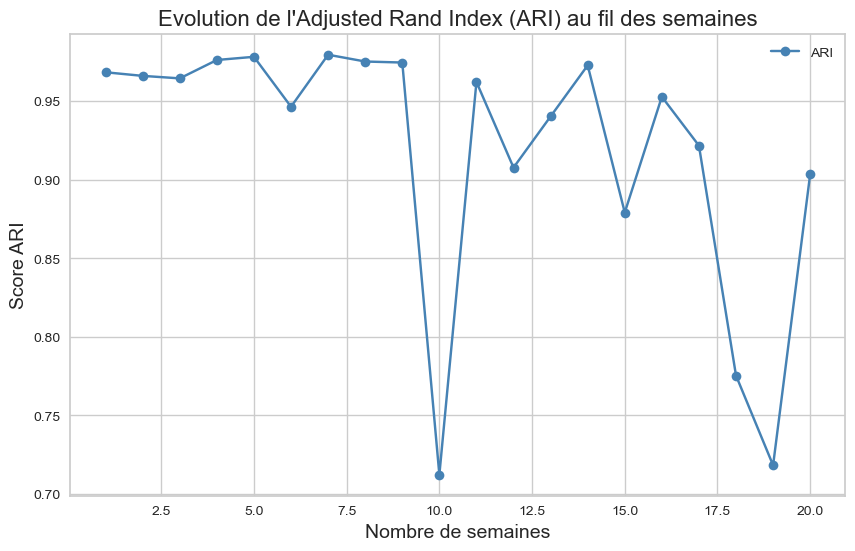

In [33]:
print_ari_scores(ari_scores)

On observe qu'au bout de la 10ème semaines, le score ARI ((Adjusted Rand Index) ) passe sous 0,75. C'est à dire le 11 mars 2018.

Il faut donc que j'augmente la date de départ pour me rapprocher de la date de fin de fichier (31/08/2018).

### 4.3 - 2ème boucle d'itérations depuis le 22/06/2018

Je démarre sur des cylces de 1 semaine depuis le 22/06/2018.

**Entraînement du modèle initial M0**

In [36]:
X_0 = get_olist_data_per_order_purchase_timestamp("2018-06-22 00:00:01")
X_0.head()

,recence,frequence,montant,score_moyen
0,42,1,129.90,5.0
1,45,1,18.90,4.0
2,468,1,69.00,3.0
3,252,1,25.99,4.0
4,219,1,180.00,5.0


Distribution avant la transformation :

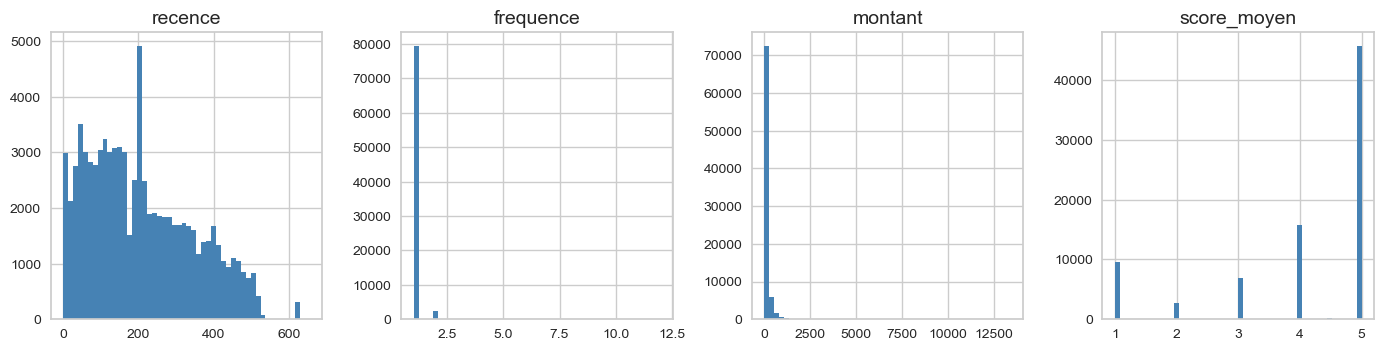

In [38]:
print_features_distribution(X_0)

Distribution après la transformation :

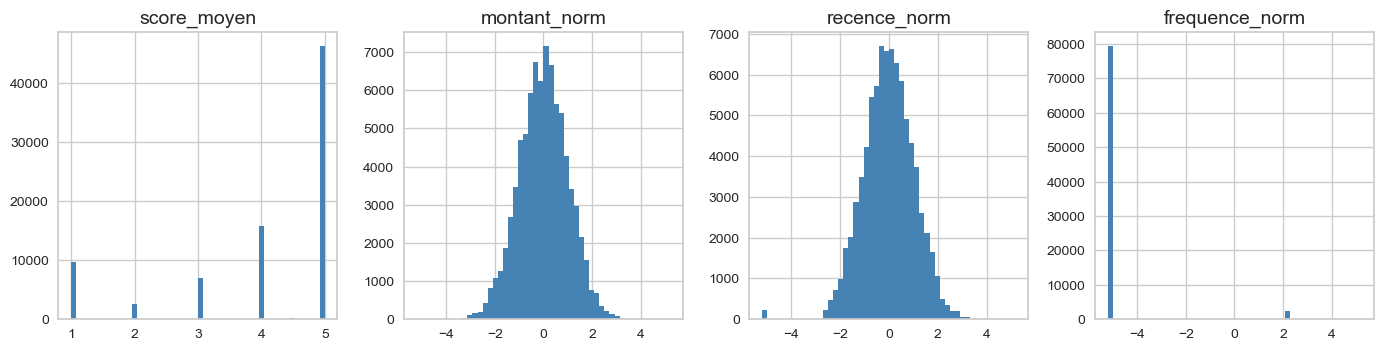

In [40]:
X_0 = transform_df(X_0)
print_features_distribution(X_0)

Centrer et réduire les données :

In [42]:
X_scale_0 = StandardScaler().fit_transform(X_0)

Entraînement :

In [44]:
M0 = KMeans(n_clusters=5, random_state=42)
C0 = M0.fit_predict(X_scale_0)

Affichage de la distribution des clusters initiale :

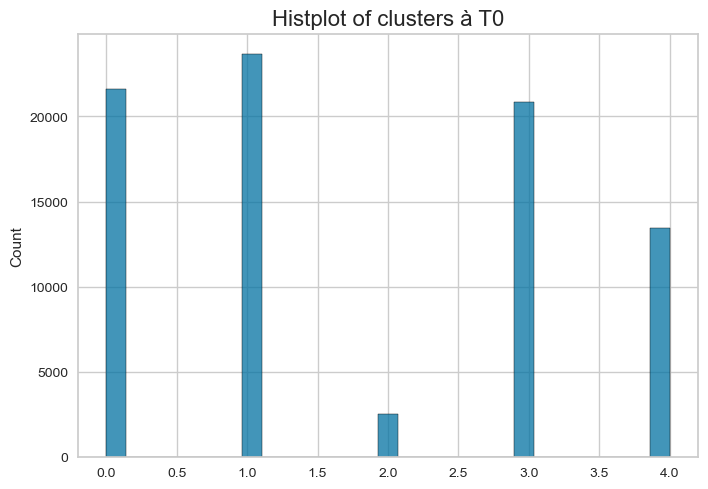

In [46]:
sns.histplot(data=C0)
plt.title('Histplot of clusters à T0', fontsize=16)
plt.show()

**Rechercher la divergence des clusters dans le temps**


Résultats ARI pour chaque cycle de 1 semaine:
Semaine 1: ARI = 0.9861857706910786
Semaine 2: ARI = 0.9466944528200895
Semaine 3: ARI = 0.8151708798373071
Semaine 4: ARI = 0.8310403251533316
Semaine 5: ARI = 0.9880346632158129
Semaine 6: ARI = 0.9601252301961665
Semaine 7: ARI = 0.8348493571733211
Semaine 8: ARI = 0.9431685946048269
Semaine 9: ARI = 0.8725399992090976
Semaine 10: ARI = 0.9269226903356808
Semaine 11: ARI = 0.6071950743752821


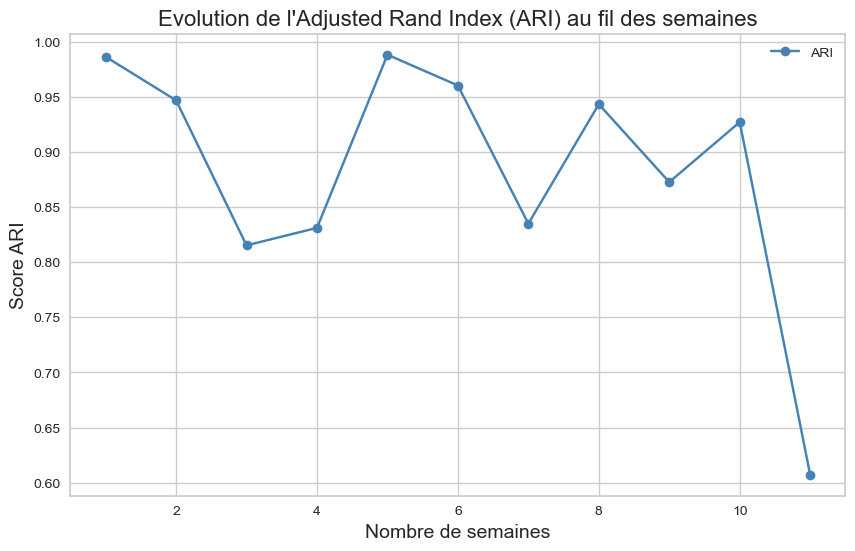

In [48]:
ari_scores = run_iterations("2018-06-22 00:00:01", 11)
print_ari_scores(ari_scores)

## 5 - Observations de la distribution des features entre le 22/01/2018 et 31/08/2018

In [ ]:


for

X = get_olist_data_per_order_purchase_timestamp("2018-06-22 00:00:01")
X_0 = transform_df(X_0)
print_features_distribution(X_0)

## 6 - Conclusions

*Il faut réentraîner le modèle au maximum toutes les 10 semaines.*